# Key metrics calculation for a game app: Retention, Lifetime, ARPU, ARPPU, Conversion rate - cohort analysis

In [13]:
import sqlite3 as sl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

In [14]:
#List of tables in database
conn = sl.connect('test.db')
cursor = conn.cursor()
cursor.execute(""" select*from sqlite_master where type = 'table' """)
tables = cursor.fetchall()

for table in tables:
    print(table[1])

level_up
payment
quest_complete
quest_start
session_close
install


## Retention

In [15]:
#Data sampling with SQL for Retention calculation:
# - convertation game session duration to minutes
# - calculation of Lifetime for each user
# - grouping by registration date and Lifetime
df_retention = pd.read_sql('''
    with t1 as (SELECT a.user_id, date(a.reg_time) as reg_date, 
    date(b.open_time) as session_date, 
    round(cast(b.duration as real)/60, 2) as duration_minutes, 
    julianday(date(b.open_time))-julianday(date(a.reg_time)) as lifetime
    FROM install as a
    JOIN session_close as b on a.user_id = b.user_id)
    
    SELECT reg_date, lifetime, count(distinct user_id) as active_users, avg(duration_minutes) as avg_duration_minutes
    FROM t1
    group by 1, 2
''', conn)

In [16]:
df_retention.dtypes

reg_date                 object
lifetime                float64
active_users              int64
avg_duration_minutes    float64
dtype: object

In [17]:
#Convertation date string format to datetime format
df_retention['reg_date'] = df_retention['reg_date'].apply(pd.to_datetime)

df_retention

,reg_date,lifetime,active_users,avg_duration_minutes
0,2020-10-05,0.0,379,18.546087
1,2020-10-05,1.0,170,10.951042
2,2020-10-05,2.0,140,10.330805
3,2020-10-05,3.0,110,11.084404
4,2020-10-05,4.0,94,12.388582
...,...,...,...,...
105,2020-10-14,6.0,430,10.524510
106,2020-10-14,7.0,408,10.886692
107,2020-10-14,8.0,382,10.466854
108,2020-10-14,9.0,358,11.148660


In [18]:
#Determination cohorts according registration date and calculation of installs quantity
df_installs = pd.read_sql('''
    SELECT date(reg_time) as reg_date, count(distinct user_id) as installs
    FROM install
    group by 1
''', conn)

df_installs['reg_date'] = pd.to_datetime(df_installs['reg_date'])
df_installs.sort_values('reg_date')

,reg_date,installs
0,2020-10-05,380
1,2020-10-06,423
2,2020-10-07,591
3,2020-10-08,1210
4,2020-10-09,4855
5,2020-10-10,8130
6,2020-10-11,7129
7,2020-10-12,4991
8,2020-10-13,1634
9,2020-10-14,1772


In [19]:
#Merging tables for Retention calculation
df_retention = df_retention.merge(df_installs, on = 'reg_date', how = 'left')

In [20]:
#Calculation of Retention
df_retention['retention'] = round(df_retention['active_users']/df_retention['installs'], 3)

df_retention

,reg_date,lifetime,active_users,avg_duration_minutes,installs,retention
0,2020-10-05,0.0,379,18.546087,380,0.997
1,2020-10-05,1.0,170,10.951042,380,0.447
2,2020-10-05,2.0,140,10.330805,380,0.368
3,2020-10-05,3.0,110,11.084404,380,0.289
4,2020-10-05,4.0,94,12.388582,380,0.247
...,...,...,...,...,...,...
105,2020-10-14,6.0,430,10.524510,1772,0.243
106,2020-10-14,7.0,408,10.886692,1772,0.230
107,2020-10-14,8.0,382,10.466854,1772,0.216
108,2020-10-14,9.0,358,11.148660,1772,0.202


In [21]:
#Retention by cohorts and lifetime
retention_pivot = df_retention.pivot_table(index='reg_date', columns='lifetime',
                                      values='retention', aggfunc='mean')

retention_pivot

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
reg_date,,,,,,,,,,,
2020-10-05,0.997,0.447,0.368,0.289,0.247,0.229,0.234,0.234,0.211,0.182,0.050
2020-10-06,1.000,0.449,0.359,0.293,0.241,0.236,0.210,0.220,0.187,0.161,0.073
2020-10-07,1.000,0.408,0.306,0.259,0.235,0.208,0.196,0.176,0.188,0.157,0.059
2020-10-08,0.995,0.295,0.211,0.195,0.161,0.149,0.152,0.143,0.117,0.114,0.033
2020-10-09,0.998,0.352,0.261,0.224,0.192,0.181,0.166,0.157,0.147,0.140,0.080
2020-10-10,0.999,0.329,0.242,0.204,0.182,0.163,0.151,0.145,0.140,0.133,0.042
2020-10-11,0.998,0.496,0.380,0.329,0.291,0.269,0.245,0.240,0.224,0.210,0.073
2020-10-12,0.998,0.492,0.390,0.347,0.301,0.274,0.263,0.253,0.240,0.219,0.029
2020-10-13,0.995,0.467,0.374,0.319,0.283,0.279,0.260,0.250,0.226,0.207,0.088


<AxesSubplot:title={'center':'User Retention'}, xlabel='lifetime', ylabel='reg_date'>

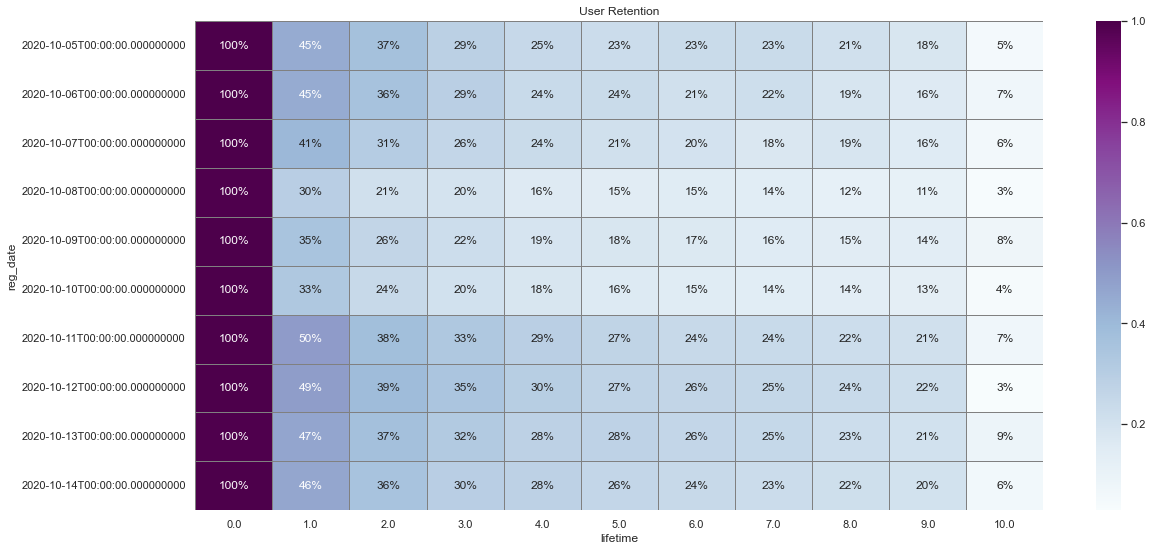

In [22]:
#Heatmap visualization of Retention by cohorts
sns.set(style='white')
plt.figure(figsize=(19, 9))
plt.title('User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.0%', linewidths=1, linecolor='gray', cmap = 'BuPu')

In [23]:
#Retention for all users
all_retention_pivot = df_retention.pivot_table(columns='lifetime',
                                      values='retention', aggfunc='mean')

all_retention_pivot

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
retention,0.9978,0.4198,0.3247,0.2754,0.2413,0.2248,0.212,0.2048,0.1896,0.1725,0.0589


## Game sessions duration

In [24]:
#Average duration of game sessions by cohorts and lifetime
duration_pivot = df_retention.pivot_table(index='reg_date', columns='lifetime',
                                      values='avg_duration_minutes', aggfunc='mean')

duration_pivot.round(2)

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
reg_date,,,,,,,,,,,
2020-10-05,18.55,10.95,10.33,11.08,12.39,13.53,12.46,10.58,11.99,12.90,17.52
2020-10-06,18.34,11.28,10.20,10.19,10.12,10.54,9.86,9.43,8.76,9.63,8.76
2020-10-07,16.50,9.82,11.19,9.43,10.42,10.62,10.27,10.48,11.32,11.35,9.80
2020-10-08,14.24,11.94,12.97,13.05,13.50,12.83,12.30,10.89,11.58,13.56,11.56
2020-10-09,16.43,12.49,11.07,11.24,11.24,10.59,11.14,11.23,11.58,11.67,12.15
2020-10-10,15.69,12.31,11.28,11.28,10.97,10.95,11.23,11.26,11.27,12.01,12.36
2020-10-11,18.47,11.86,11.12,10.64,11.13,11.20,11.25,11.52,11.32,11.48,12.65
2020-10-12,17.67,11.93,11.32,11.36,11.87,12.55,11.62,11.53,11.41,12.51,13.51
2020-10-13,19.90,12.65,12.53,12.36,12.20,13.00,12.60,11.88,12.88,12.61,10.53


<AxesSubplot:title={'center':'Average Session Duration, minutes'}, xlabel='lifetime', ylabel='reg_date'>

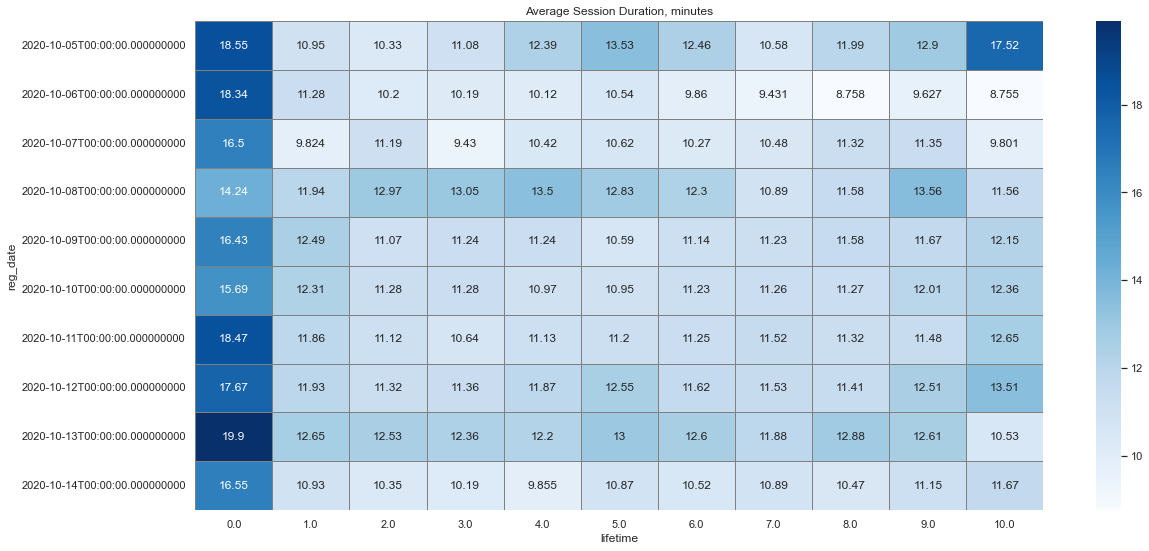

In [25]:
#Heatmap visualization of Average game session duration by cohorts
sns.set(style='white')
plt.figure(figsize=(19, 9))
plt.title('Average Session Duration, minutes')
sns.heatmap(duration_pivot, annot=True, fmt='.4g', linewidths=1, linecolor='gray', cmap = 'Blues')

In [26]:
#Average game session duration for all users
all_duration_pivot = df_retention.pivot_table(columns='lifetime',
                                      values='avg_duration_minutes', aggfunc='mean')

all_duration_pivot.round(2)

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
avg_duration_minutes,17.23,11.62,11.24,11.08,11.37,11.67,11.32,10.97,11.26,11.89,12.05


## Passing the levels

In [27]:
#Data sampling with SQL
df_level = pd.read_sql('''
    with t1 as (SELECT a.user_id, date(a.reg_time) as reg_date, date(b.time) as new_level_date, b.level
    FROM install as a
    LEFT JOIN level_up as b on a.user_id=b.user_id
    group by 1, 2, 3, 4),
    
    t2 as (SELECT date(reg_time) as reg_date, count(distinct user_id) as installs
    FROM install
    group by 1)
    
    SELECT t1.reg_date, t1.level, t2.installs, count(t1.user_id) as active_users
    FROM t1
    LEFT JOIN t2 on t1.reg_date=t2.reg_date
    group by 1, 2, 3
    
    
''', conn)

In [28]:
#Calculation of the percentage of users who passed the levels
df_level['percentage'] = (df_level['active_users'] / df_level['installs']).round(2)

df_level.head()

,reg_date,level,installs,active_users,percentage
0,2020-10-05,NaN,380,69,0.18
1,2020-10-05,2.0,380,311,0.82
2,2020-10-05,3.0,380,283,0.74
3,2020-10-05,4.0,380,247,0.65
4,2020-10-05,5.0,380,217,0.57


In [29]:
#Passing the levels by cohorts (quantity)
level_pivot = df_level.pivot_table(index='reg_date', columns='level',
                                      values='active_users', aggfunc='mean')

level_pivot.fillna('')

level,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
reg_date,,,,,,,,,,,,,,,,,,,,
2020-10-05,311.0,283.0,247.0,217.0,191.0,181.0,150.0,96.0,62.0,43.0,30.0,17.0,10.0,4.0,2.0,,,,,
2020-10-06,337.0,302.0,266.0,221.0,202.0,191.0,166.0,92.0,60.0,42.0,21.0,10.0,2.0,2.0,2.0,2.0,1.0,,,
2020-10-07,478.0,391.0,315.0,266.0,235.0,227.0,192.0,128.0,74.0,48.0,31.0,10.0,7.0,5.0,2.0,1.0,,,,
2020-10-08,934.0,715.0,518.0,383.0,317.0,305.0,252.0,148.0,92.0,58.0,33.0,14.0,8.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-10-09,3737.0,2952.0,2297.0,1764.0,1543.0,1455.0,1229.0,804.0,479.0,304.0,181.0,98.0,51.0,15.0,8.0,3.0,1.0,1.0,,
2020-10-10,6202.0,4724.0,3665.0,2756.0,2412.0,2289.0,1990.0,1281.0,797.0,516.0,298.0,163.0,74.0,27.0,11.0,1.0,1.0,1.0,,
2020-10-11,6192.0,5441.0,4754.0,3989.0,3555.0,3374.0,2912.0,1842.0,1127.0,742.0,421.0,206.0,97.0,45.0,22.0,5.0,,,,
2020-10-12,4461.0,3994.0,3531.0,2956.0,2624.0,2486.0,2121.0,1366.0,829.0,538.0,327.0,165.0,77.0,37.0,15.0,5.0,2.0,1.0,,
2020-10-13,1380.0,1230.0,1086.0,915.0,797.0,761.0,641.0,425.0,267.0,187.0,118.0,69.0,33.0,18.0,6.0,1.0,,,,


In [30]:
#Passing the levels by cohorts (percentage)
level_pivot_percentage = df_level.pivot_table(index='reg_date', columns='level',
                                      values='percentage', aggfunc='mean')
level_pivot_percentage.round(2).fillna('')

level,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
reg_date,,,,,,,,,,,,,,,,,,,,
2020-10-05,0.82,0.74,0.65,0.57,0.50,0.48,0.39,0.25,0.16,0.11,0.08,0.04,0.03,0.01,0.01,,,,,
2020-10-06,0.80,0.71,0.63,0.52,0.48,0.45,0.39,0.22,0.14,0.10,0.05,0.02,0.00,0.00,0.00,0.0,0.0,,,
2020-10-07,0.81,0.66,0.53,0.45,0.40,0.38,0.32,0.22,0.13,0.08,0.05,0.02,0.01,0.01,0.00,0.0,,,,
2020-10-08,0.77,0.59,0.43,0.32,0.26,0.25,0.21,0.12,0.08,0.05,0.03,0.01,0.01,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2020-10-09,0.77,0.61,0.47,0.36,0.32,0.30,0.25,0.17,0.10,0.06,0.04,0.02,0.01,0.00,0.00,0.0,0.0,0.0,,
2020-10-10,0.76,0.58,0.45,0.34,0.30,0.28,0.24,0.16,0.10,0.06,0.04,0.02,0.01,0.00,0.00,0.0,0.0,0.0,,
2020-10-11,0.87,0.76,0.67,0.56,0.50,0.47,0.41,0.26,0.16,0.10,0.06,0.03,0.01,0.01,0.00,0.0,,,,
2020-10-12,0.89,0.80,0.71,0.59,0.53,0.50,0.42,0.27,0.17,0.11,0.07,0.03,0.02,0.01,0.00,0.0,0.0,0.0,,
2020-10-13,0.84,0.75,0.66,0.56,0.49,0.47,0.39,0.26,0.16,0.11,0.07,0.04,0.02,0.01,0.00,0.0,,,,


<AxesSubplot:title={'center':'User Level up'}, xlabel='level', ylabel='reg_date'>

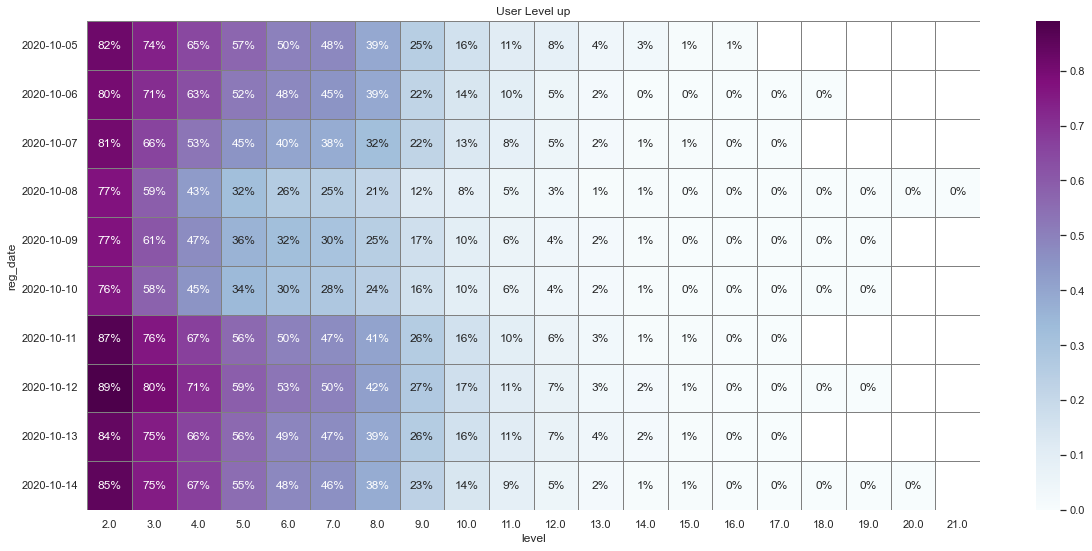

In [31]:
#Heatmap visualization of passing the levels by cohorts
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('User Level up')
sns.heatmap(level_pivot_percentage, annot=True, fmt='.0%', linewidths=1, linecolor='gray', cmap = 'BuPu')

[Text(0.5, 1.0, 'Passing the levels'),
 Text(0.5, 0, 'Level'),
 Text(0, 0.5, 'Active Users')]

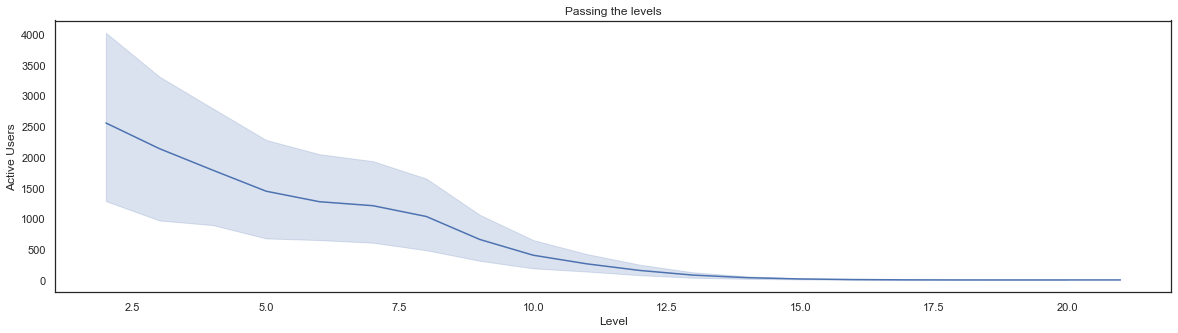

In [32]:
fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x = 'level', y = 'active_users', data = df_level).set(title = 'Passing the levels', xlabel = 'Level', ylabel = 'Active Users')

## Completing the quests

In [33]:
#Data sampling with SQL:
# - splitting strings with quest names for getting only numbers of the quests (for visualization)
df_quest = pd.read_sql('''
    with t1 as (SELECT a.user_id, date(a.reg_time) as reg_date, date(b.time) as new_quest_date, substr(b.quest, 7) as quest_number
    FROM install as a
    LEFT JOIN quest_start as b on a.user_id=b.user_id
    group by 1, 2, 3, 4),
    
    t2 as (SELECT date(reg_time) as reg_date, count(distinct user_id) as installs
    FROM install
    group by 1)
    
    SELECT t1.reg_date, t1.quest_number, t2.installs, count(t1.user_id) as active_users
    FROM t1
    LEFT JOIN t2 on t1.reg_date=t2.reg_date
    group by 1, 2, 3
    
    
''', conn)

In [34]:
#Filtering notnull values and converting numbers of the quests to integer format
df_quest = df_quest[df_quest['quest_number'].notnull()]
df_quest['quest_number'] = df_quest['quest_number'].astype(str).astype(int)

In [35]:
#Calculation of the percentage of users who completed the quests
df_quest['percentage'] = df_quest['active_users'] / df_quest['installs']

df_quest

,reg_date,quest_number,installs,active_users,percentage
1,2020-10-05,0,380,328,0.863158
2,2020-10-05,1,380,312,0.821053
3,2020-10-05,10,380,223,0.586842
4,2020-10-05,11,380,220,0.578947
5,2020-10-05,12,380,217,0.571053
...,...,...,...,...,...
725,2020-10-14,73,1772,4,0.002257
726,2020-10-14,74,1772,4,0.002257
727,2020-10-14,75,1772,4,0.002257
728,2020-10-14,8,1772,1027,0.579571


In [36]:
#Completing the quests by cohorts (percentage)
quest_pivot_percentage = df_quest.pivot_table(index='reg_date', columns='quest_number',
                                      values='percentage', aggfunc='mean')

quest_pivot_percentage.round(2).fillna('')

quest_number,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
reg_date,,,,,,,,,,,,,,,,,,,,,
2020-10-05,0.86,0.82,0.78,0.78,0.70,0.67,0.65,0.63,0.59,0.59,...,,,,,,,,,,
2020-10-06,0.84,0.80,0.76,0.75,0.66,0.65,0.62,0.59,0.55,0.55,...,,,,,,,,,,
2020-10-07,0.86,0.80,0.74,0.74,0.61,0.56,0.52,0.51,0.47,0.47,...,,,,,,,,,,
2020-10-08,0.85,0.79,0.68,0.68,0.51,0.46,0.41,0.38,0.34,0.34,...,,,,,,,,,,
2020-10-09,0.85,0.80,0.71,0.70,0.54,0.50,0.45,0.42,0.39,0.39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-10,0.85,0.79,0.69,0.69,0.51,0.48,0.43,0.39,0.36,0.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,
2020-10-11,0.92,0.88,0.82,0.82,0.71,0.69,0.65,0.62,0.59,0.59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-12,0.93,0.90,0.85,0.85,0.75,0.73,0.69,0.66,0.62,0.62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-13,0.88,0.85,0.80,0.80,0.71,0.68,0.65,0.62,0.59,0.59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:title={'center':'Completing the quests'}, xlabel='quest_number', ylabel='reg_date'>

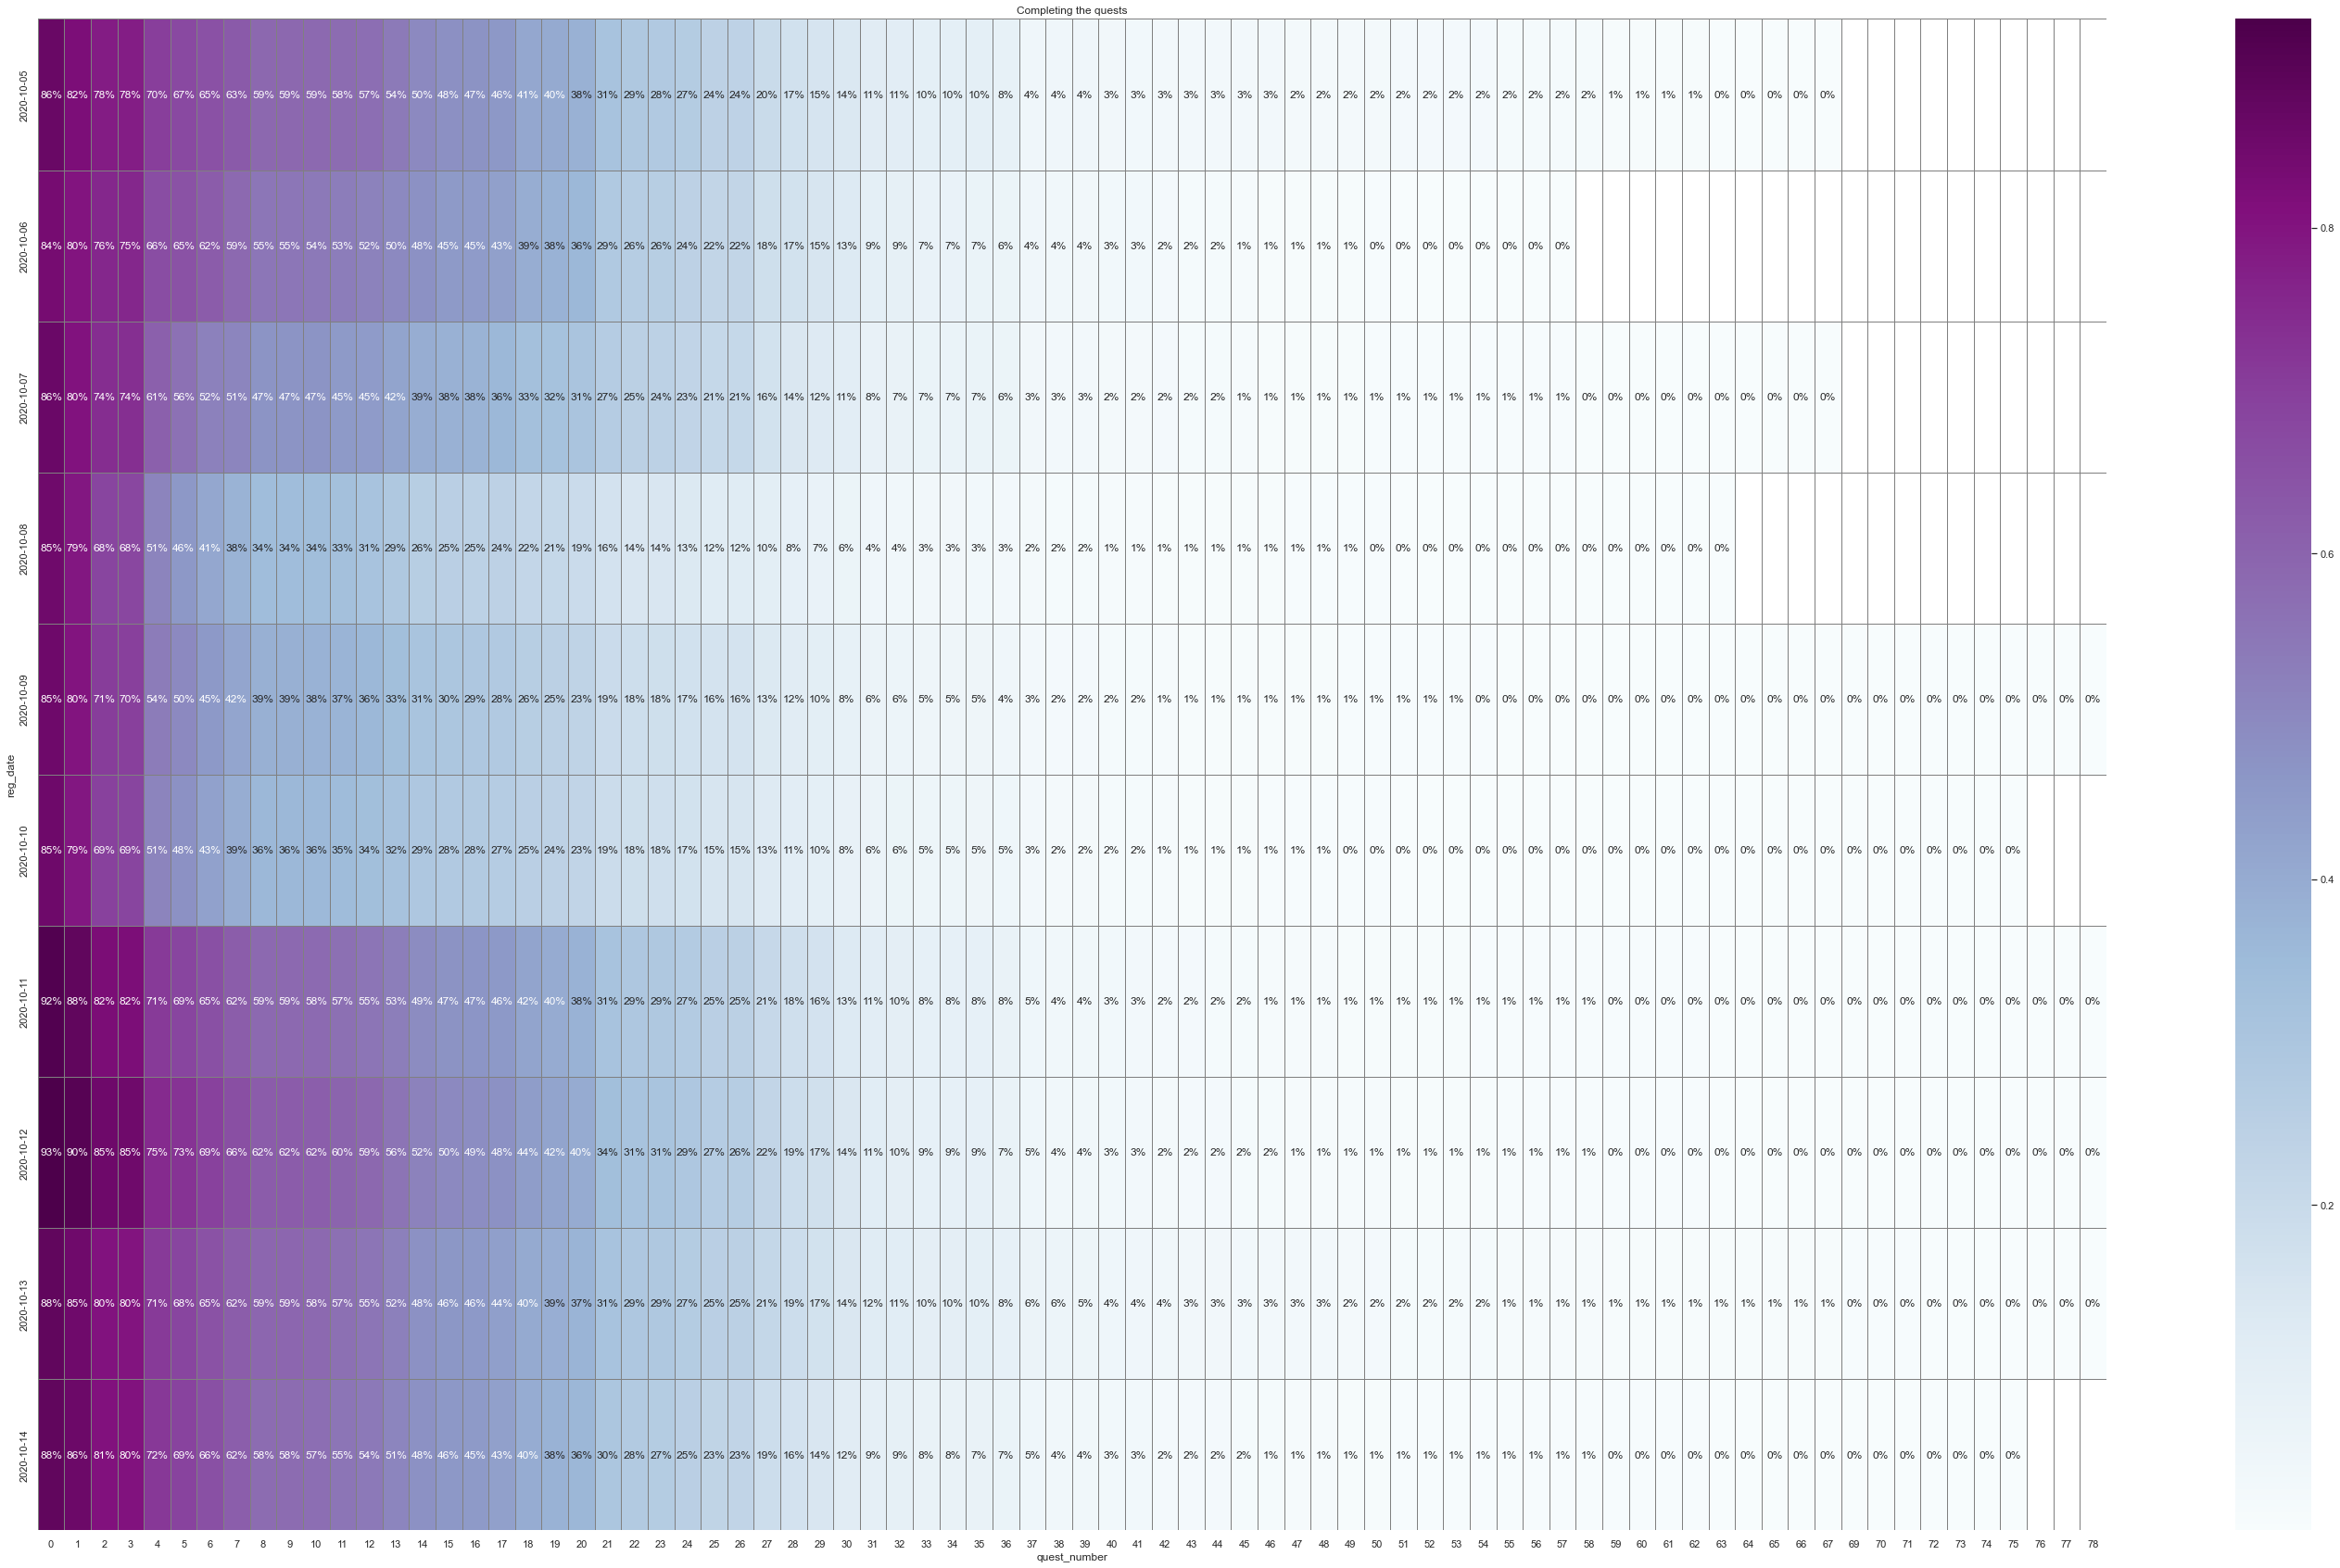

In [39]:
#Heatmap of completing the quests by cohorts
sns.set(style='white')
plt.figure(figsize=(50, 30))
plt.title('Completing the quests')
sns.heatmap(quest_pivot_percentage, annot=True, fmt='.0%', linewidths=1, linecolor='gray', cmap = 'BuPu')

[Text(0.5, 1.0, 'Completing the quests'),
 Text(0.5, 0, 'Quest'),
 Text(0, 0.5, 'Active Users')]

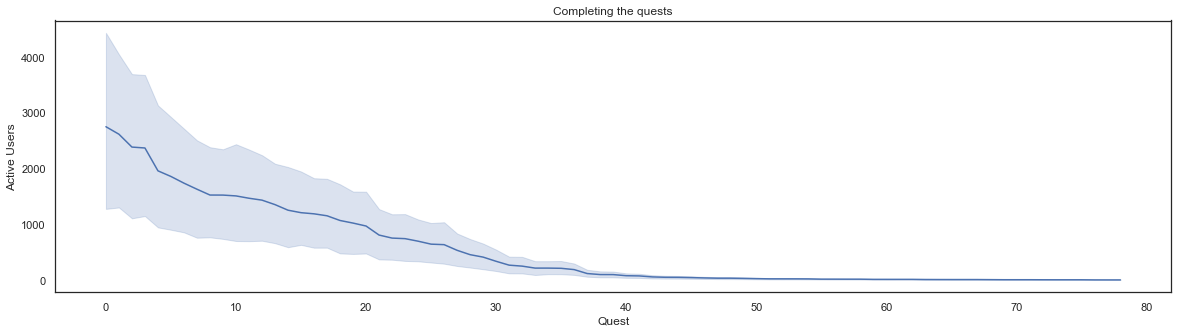

In [40]:
fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x = 'quest_number', y = 'active_users', data = df_quest).set(title = 'Completing the quests', xlabel = 'Quest', ylabel = 'Active Users')

## Monetizaton metrics

In [41]:
#Data sampling with SQL:
# - determining quantity of active users who were active at least 1 time
# - determining paying users
# - calculation of Revenue
df_monetization = pd.read_sql('''
   with t1 as (SELECT date(a.reg_time) as reg_date, count(distinct b.user_id) as active_users
   FROM install as a
   LEFT JOIN session_close as b on a.user_id=b.user_id
   group by 1),
   
   t2 as (SELECT date(a.reg_time) as reg_date, count(distinct b.user_id) as paying_users, sum(b.amount) as revenue
   FROM install as a
   LEFT JOIN payment as b on a.user_id=b.user_id
   group by 1)
   
   SELECT t1.reg_date, t1.active_users, t2.paying_users, t2.revenue
   FROM t1
   LEFT JOIN t2 on t1.reg_date=t2.reg_date
    
''', conn)

In [42]:
#Calculation of ARPU, ARPPU and Conversion rate for 10 days by cohorts
df_monetization['ARPU'] = df_monetization['revenue'] / df_monetization['active_users']
df_monetization['ARPPU'] = df_monetization['revenue'] / df_monetization['paying_users']
df_monetization['conversion_rate'] = (df_monetization['paying_users'] / df_monetization['active_users'])*100

In [43]:
df_monetization

,reg_date,active_users,paying_users,revenue,ARPU,ARPPU,conversion_rate
0,2020-10-05,379,2,3.202290,0.008449,1.601145,0.527704
1,2020-10-06,423,6,3.046565,0.007202,0.507761,1.418440
2,2020-10-07,591,8,9.981679,0.016889,1.247710,1.353638
3,2020-10-08,1208,2,0.609160,0.000504,0.304580,0.165563
4,2020-10-09,4847,18,56.990076,0.011758,3.166115,0.371364
5,2020-10-10,8126,19,7.838931,0.000965,0.412575,0.233817
6,2020-10-11,7116,49,16.963359,0.002384,0.346191,0.688589
7,2020-10-12,4983,47,35.807634,0.007186,0.761865,0.943207
8,2020-10-13,1629,92,162.148092,0.099538,1.762479,5.647637
9,2020-10-14,1770,70,85.151908,0.048108,1.216456,3.954802


[Text(0.5, 1.0, 'Conversion rate')]

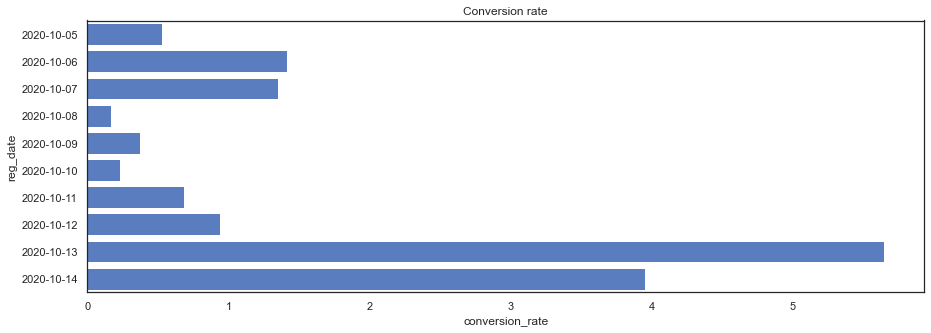

In [44]:
#Visualization of Conversion rate by cohorts
f, ax = plt.subplots(figsize=(15, 5))
sns.set_color_codes("muted")
sns.barplot(x='conversion_rate', y='reg_date', data=df_monetization,
            color='b').set(title='Conversion rate')

In [45]:
#Data sampling with SQL:
# - calculation of accumulative ARPU by lifetime
df_arpu = pd.read_sql('''
    with t1 as (SELECT a.user_id, date(a.reg_time) as reg_date, 
    date(b.open_time) as session_date,
    julianday(date(b.open_time))-julianday(date(a.reg_time)) as lifetime 
    FROM install as a
    JOIN session_close as b on a.user_id = b.user_id),
    
    t2 as (SELECT t1.reg_date, t1.lifetime, count(distinct t1.user_id) as active_users, sum(c.amount) as revenue,
    sum(c.amount)/count(distinct t1.user_id) as ARPU
    FROM t1
    LEFT JOIN payment as c on t1.user_id=c.user_id
    group by 1, 2)
    
    SELECT lifetime,
    sum(ARPU) over (order by lifetime rows between unbounded preceding and current row) as cum_arpu
    FROM t2
    group by 1
    
''', conn)

In [46]:
df_arpu

,lifetime,cum_arpu
0,0.0,0.008449
1,1.0,0.049707
2,2.0,0.127029
3,3.0,0.188022
4,4.0,0.194502
5,5.0,0.198003
6,6.0,0.198003
7,7.0,0.198003
8,8.0,0.198003
9,9.0,0.198003


<AxesSubplot:xlabel='lifetime', ylabel='cum_arpu'>

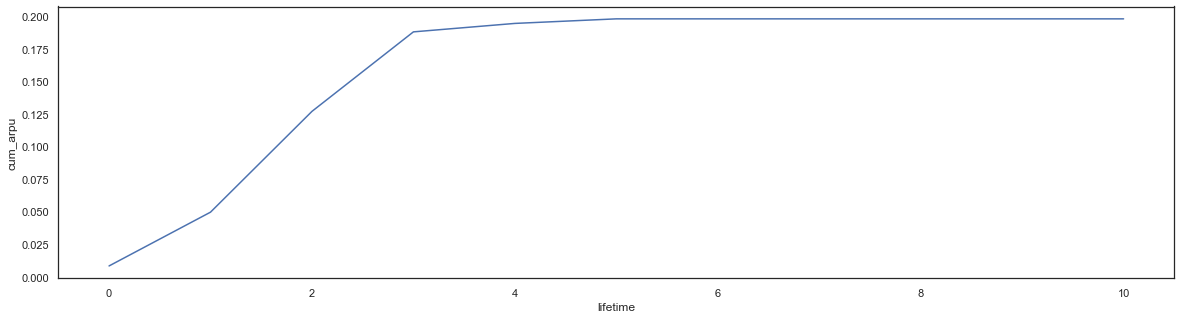

In [47]:
#Visualization of accumulative ARPU
fig = plt.subplots(figsize=(20, 5))
sns.lineplot(data=df_arpu, x='lifetime', y='cum_arpu')

## First payments

In [48]:
#Data sampling with SQL:
# - determinig of date of first payment with window function
df_first_payment = pd.read_sql('''
    with t1 as (SELECT a.user_id, date(a.reg_time) as reg_date, 
    date(b.open_time) as session_date
    FROM install as a
    JOIN session_close as b on a.user_id = b.user_id),
    
    t2 as (SELECT t1.user_id, t1.reg_date, t1.session_date, 
    first_value(date(c.time)) over (partition by t1.user_id order by date(c.time) ASC) as payment_date
    FROM t1
    LEFT JOIN payment as c on t1.user_id = c.user_id)
    
    SELECT user_id, reg_date, session_date, payment_date
    FROM t2
    where session_date=payment_date
    
    
''', conn)

In [49]:
##Convertation date string format to datetime format
df_first_payment[['reg_date', 'session_date', 'payment_date']] = df_first_payment[['reg_date', 'session_date', 'payment_date']].apply(pd.to_datetime)

In [50]:
#Calculation of lifetime from registration date to session date
df_first_payment['lifetime'] = (df_first_payment['session_date'] - df_first_payment['reg_date']).dt.days

df_first_payment.head()

,user_id,reg_date,session_date,payment_date,lifetime
0,108116306,2020-10-12,2020-10-12,2020-10-12,0
1,108116306,2020-10-12,2020-10-12,2020-10-12,0
2,108116306,2020-10-12,2020-10-12,2020-10-12,0
3,110213686,2020-10-14,2020-10-14,2020-10-14,0
4,110213686,2020-10-14,2020-10-14,2020-10-14,0


In [51]:
#Grouping by lifetime and calculation of percentage of paying users
df_first_payment_chart = df_first_payment.groupby('lifetime').agg({'user_id':'nunique'}).reset_index().rename(columns = {'user_id':'paying_users'})
df_first_payment_chart['percentage'] = (df_first_payment_chart['paying_users'] / df_first_payment_chart['paying_users'].sum())*100

df_first_payment_chart

,lifetime,paying_users,percentage
0,0,113,36.102236
1,1,71,22.683706
2,2,37,11.821086
3,3,28,8.945687
4,4,14,4.472843
5,5,22,7.028754
6,6,10,3.194888
7,7,10,3.194888
8,8,3,0.958466
9,9,4,1.277955


[Text(0.5, 1.0, 'Distribution of first payments'),
 Text(0.5, 0, 'Lifetime'),
 Text(0, 0.5, 'Users')]

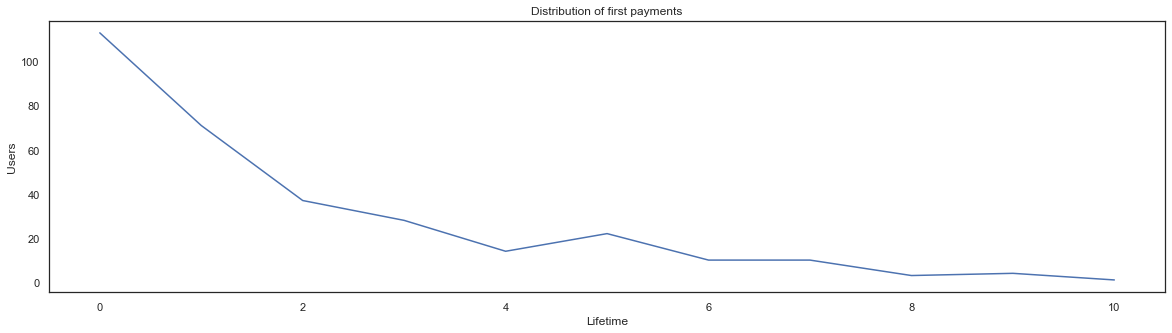

In [52]:
#The chart of distribution of first payments according lifetime
fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x = 'lifetime', y = 'paying_users', data = df_first_payment_chart).set(title = 'Distribution of first payments', xlabel = 'Lifetime', ylabel = 'Users')

[Text(0.5, 1.0, 'Distribution of first payments, percentage')]

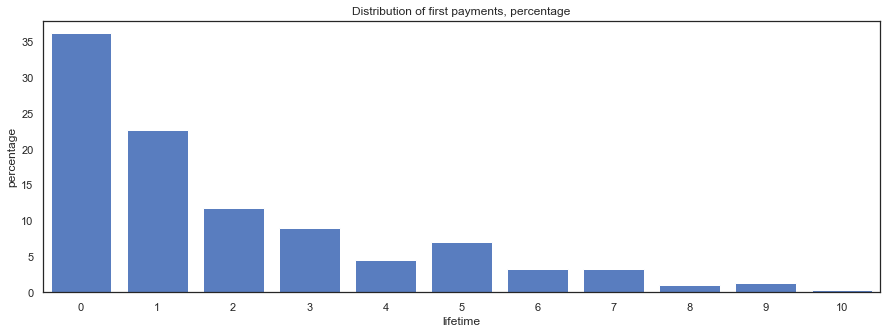

In [53]:
#Visualization of percentage of first payments
f, ax = plt.subplots(figsize=(15, 5))
sns.set_color_codes("muted")
sns.barplot(x = 'lifetime', y = 'percentage', data = df_first_payment_chart,
            color='b').set(title='Distribution of first payments, percentage')

**Possible activities to increase Retention and increase the duration of sessions:**

- adding an entry calendar, for example, for 30 days, when every day players receive some kind of bonus for entering the game,
- setting up notifications,
- testing a new tutorial to increase player engagement,
- setting up a personalized discount system for in-game purchases.